In [1]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

In [2]:
struct Grid
    x::Vector{Float64}
    y::Vector{Float64}
    nx::Int64
    ny::Int64
    W::Float64
    H::Float64
    dx::Float64
    dy::Float64
    solution::Matrix{Float64}
    rhs::Matrix{Float64}
    residual::Matrix{Float64}
    Grid(W,H,nx,ny) = new(LinRange(0,W,nx),LinRange(0,H,ny),nx,ny,W,H,W/(nx-1),H/(ny-1),zeros(ny,nx),zeros(ny,nx),zeros(ny,nx))
end

@inline even(x) = x%2==0

function poisson_smoother!(grid::Grid,cycles::Int64)
    local coef_center = -2/grid.dx^2 -2/grid.dy^2
    local coef_right = 1/grid.dx^2
    local coef_left = 1/grid.dx^2
    local coef_up = 1/grid.dy^2
    local coef_down = 1/grid.dy^2
    local theta = 1.75;
    local cycle::Int64 = 1
    local this_residual::Float64
    while cycle <= cycles
        #red-black update
        for redblack in 1:2
            for j in 2:(grid.nx-1)#jstart:2:(grid.nx-1)
                istart::Int64 = even(redblack) != even(j) ? 2 : 3#(even(cycle) ? 2 : 3) : (even(cycle) ? 3 : 2)
                for i in istart:2:(grid.ny-1)
                    # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
                    local this_residual = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
                    grid.solution[i,j] += theta*this_residual/coef_center
                end            
            end
        end
        cycle += 1
    end
    for j in 2:(grid.nx-1)
        for i in 2:(grid.ny-1) # julia is column-major - inner loop over columns
            # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
            # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
            grid.residual[i,j] = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
        end
    end
end

function poisson_restriction!(fine::Grid,coarse::Grid,mgunit::Int64)
    # restriction (fine) -> (coarse)
    local wt = zeros(coarse.ny,coarse.nx)
    coarse.rhs[:,:] .= 0.0
    for j in 1:fine.nx
        jc::Int64 = Int64(floor(fine.x[j]/coarse.dx) + 1)
        jc = jc > coarse.nx-1 ? coarse.nx-1 : jc
        dx::Float64 = (fine.x[j] - coarse.x[jc])/coarse.dx
        
        for i in 1:fine.ny
           ic::Int64 = Int64(floor(fine.y[i]/coarse.dy) + 1)
           ic = ic > coarse.ny-1 ? coarse.ny-1 : ic
           dy::Float64 = (fine.y[i] - coarse.y[ic])/coarse.dy
            
           wt[ic,jc] += (1.0-dx)*(1.0-dy)
           coarse.rhs[ic,jc] += fine.residual[i,j]*(1.0-dx)*(1.0-dy)
           
           wt[ic+1,jc] += (1.0-dx)*(dy)
           coarse.rhs[ic+1,jc] += fine.residual[i,j]*(1.0-dx)*(dy)
            
           wt[ic,jc+1] += (dx)*(1.0-dy)
           coarse.rhs[ic,jc+1] += fine.residual[i,j]*(dx)*(1.0-dy)
            
           wt[ic+1,jc+1] += (dx)*(dy)
           coarse.rhs[ic+1,jc+1] += fine.residual[i,j]*(dx)*(dy)        
            
        end
    end
    coarse.rhs[:,:] = coarse.rhs./wt
end

function poisson_prolongation(fine::Grid,coarse::Grid,mgunit::Int64)
    dsol = zeros(fine.ny,fine.nx)
    # use bilinear interpolation to go from coarse to fine
    for j in 2:fine.nx-1
        local coarse_j::Int64 = Int64( floor( fine.x[j]/coarse.dx )+1 )
        local dx::Float64 = (fine.x[j]-coarse.x[coarse_j])/coarse.dx
        
        for i in 2:fine.ny-1
            local coarse_i::Int64 = Int64( floor( fine.y[i]/coarse.dy) + 1)
            local dy::Float64 = (fine.y[i]-coarse.y[coarse_i]) / coarse.dy
            
            dsol[i,j] += (1.0-dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j]
            dsol[i,j] += (1.0-dx)*(dy)*coarse.solution[coarse_i+1,coarse_j]
            dsol[i,j] += (dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j+1]
            dsol[i,j] += (dx)*(dy)*coarse.solution[coarse_i+1,coarse_j+1]
        end
    end
    return dsol
end

function poisson_prolongation!(fine::Grid,coarse::Grid,mgunit::Int64)
    #dsol = zeros(fine.ny,fine.nx)
    # use bilinear interpolation to go from coarse to fine
    local coarse_j::Int64
    local coarse_i::Int64
    local dx::Float64
    local dy::Float64
    for j in 2:fine.nx-1
        local coarse_j::Int64 = Int64( floor(fine.x[j]/coarse.dx )+1 )
        local dx::Float64 = (fine.x[j]-coarse.x[coarse_j])/coarse.dx
        
        for i in 2:fine.ny-1
            local coarse_i::Int64 = Int( floor( fine.y[i]/coarse.dy) + 1)
            local dy::Float64 = (fine.y[i]-coarse.y[coarse_i]) / coarse.dy
            
            fine.solution[i,j] += (1.0-dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j] +
            + (1.0-dx)*(dy)*coarse.solution[coarse_i+1,coarse_j] +
            + (dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j+1] +
            + (dx)*(dy)*coarse.solution[coarse_i+1,coarse_j+1]
        end
    end
end

poisson_prolongation! (generic function with 1 method)

20×21 Matrix{Int64}:
 0    0    0    0    0    0    0    0  …    0    0    0    0    0    0  0
 0  172   10  190   28  208   46  226     118  298  136  316  154  334  0
 0    1  181   19  199   37  217   55     289  127  307  145  325  163  0
 0  173   11  191   29  209   47  227     119  299  137  317  155  335  0
 0    2  182   20  200   38  218   56     290  128  308  146  326  164  0
 0  174   12  192   30  210   48  228  …  120  300  138  318  156  336  0
 0    3  183   21  201   39  219   57     291  129  309  147  327  165  0
 0  175   13  193   31  211   49  229     121  301  139  319  157  337  0
 0    4  184   22  202   40  220   58     292  130  310  148  328  166  0
 0  176   14  194   32  212   50  230     122  302  140  320  158  338  0
 0    5  185   23  203   41  221   59  …  293  131  311  149  329  167  0
 0  177   15  195   33  213   51  231     123  303  141  321  159  339  0
 0    6  186   24  204   42  222   60     294  132  312  150  330  168  0
 0  178   16  196

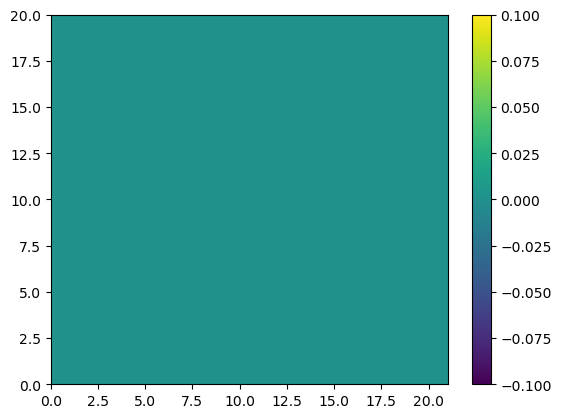

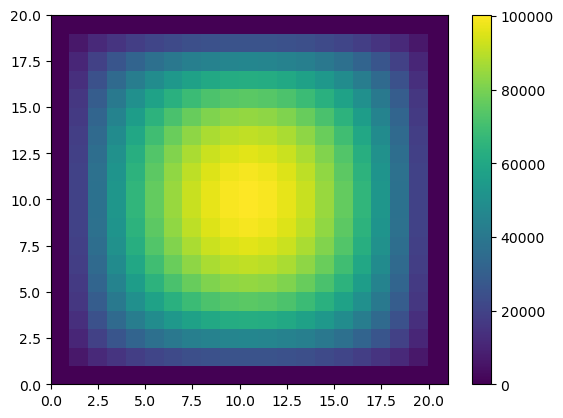

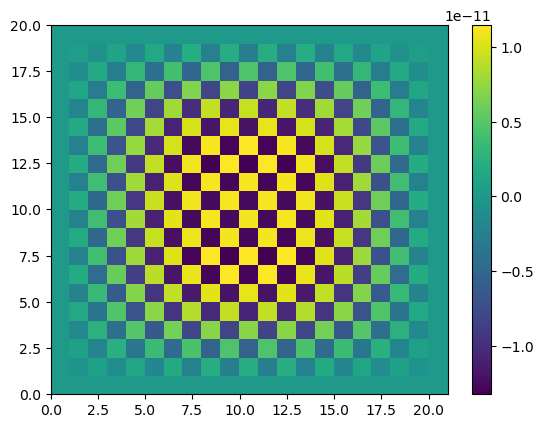

1.450179621022439e-10


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/maxrudolph/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [3]:
# test poisson red/black smoother for a small problem
nx = 21
ny = 20
width = 1e3
height = 1.5e3
grid = Grid(width,height,nx,ny)
grid1 = Grid(width,height,nx,ny)

grid.rhs[2:end-1,2:end-1] .= 1.0

function test_redblack(grid::Grid)
    order = zeros(Int64,grid.ny,grid.nx)
    counter = 1
    cycle=1
    for redblack in 1:2
           for j in 2:(grid.nx-1)#jstart:2:(grid.nx-1)
                istart::Int64 = even(redblack) != even(j) ? (even(cycle) ? 2 : 3) : (even(cycle) ? 3 : 2)
                for i in istart:2:(grid.ny-1)                # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
                order[i,j] = counter
                counter += 1
            end            
        end
    end
    return order
end

order = test_redblack(grid)
display(order)

using PyPlot
figure()
pcolor(grid.solution)
colorbar()
show()

poisson_smoother!(grid,100)
poisson_smoother!(grid1,101)
println(norm(grid.residual))

figure()
pcolor(grid1.solution-grid.solution)
colorbar()
show()
figure()
pcolor(grid1.residual-grid.residual)
colorbar()
show()

In [4]:
# Test prolongation and restriction operators for a small problem
nx = 9
ny = 11
width = 1e3
height = 1.5e3

# Define levels of grid
nlevel=2
mgunit=2
grids = Vector{Grid}()
cycles = Vector{Int64}()
for level in 1:nlevel
    level_nx = Int((nx-1)/mgunit^(level-1)+1)
    level_ny = Int((ny-1)/mgunit^(level-1)+1)
    println(level_nx,' ', level_ny)
    push!(grids, Grid(width,height,level_nx,level_ny) )
    push!(cycles,2^(nlevel-level+1)*5)
end

# assign some (arbitrary) numbers to the residual
for i=1:grids[1].ny
    for j in 1:grids[1].nx
        grids[1].residual[i,j] = i^2
    end
end

poisson_restriction!(grids[1],grids[2],mgunit)

show(stdout,"text/plain",grids[1].residual)

show(stdout,"text/plain",grids[2].rhs)

grids[2].solution[:,:] = grids[2].rhs[:,:]
dsol = poisson_prolongation(grids[1],grids[2],mgunit)


9 11
5 6
11×9 Matrix{Float64}:
   1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0
   4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0
   9.0    9.0    9.0    9.0    9.0    9.0    9.0    9.0    9.0
  16.0   16.0   16.0   16.0   16.0   16.0   16.0   16.0   16.0
  25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0
  36.0   36.0   36.0   36.0   36.0   36.0   36.0   36.0   36.0
  49.0   49.0   49.0   49.0   49.0   49.0   49.0   49.0   49.0
  64.0   64.0   64.0   64.0   64.0   64.0   64.0   64.0   64.0
  81.0   81.0   81.0   81.0   81.0   81.0   81.0   81.0   81.0
 100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
 121.0  121.0  121.0  121.0  121.0  121.0  121.0  121.0  121.06×5 Matrix{Float64}:
   2.0    2.0    2.0    2.0    2.0
   9.5    9.5    9.5    9.5    9.5
  25.5   25.5   25.5   25.5   25.5
  49.5   49.5   49.5   49.5   49.5
  81.5   81.5   81.5   81.5   81.5
 114.0  114.0  114.0  114.0  114.0

11×9 Matrix{Float64}:
 0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0
 0.0   5.75   5.75   5.75   5.75   5.75   5.75   5.75  0.0
 0.0   9.5    9.5    9.5    9.5    9.5    9.5    9.5   0.0
 0.0  17.5   17.5   17.5   17.5   17.5   17.5   17.5   0.0
 0.0  25.5   25.5   25.5   25.5   25.5   25.5   25.5   0.0
 0.0  37.5   37.5   37.5   37.5   37.5   37.5   37.5   0.0
 0.0  49.5   49.5   49.5   49.5   49.5   49.5   49.5   0.0
 0.0  65.5   65.5   65.5   65.5   65.5   65.5   65.5   0.0
 0.0  81.5   81.5   81.5   81.5   81.5   81.5   81.5   0.0
 0.0  97.75  97.75  97.75  97.75  97.75  97.75  97.75  0.0
 0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0

In [5]:
# define an indexing function that maps from (i,j) node numbering to an integer index
nx = 513
ny = 1025
width = 1e3
height = 1.5e3

# Define levels of grid
nlevel=7
mgunit=2
grids = Vector{Grid}() # grids to use with multigrid solver
cycles = Vector{Int64}() # number of gauss-seidel iterations to take at each multigrid level
for level in 1:nlevel
    level_nx = Int64((nx-1)/mgunit^(level-1)+1)
    level_ny = Int64((ny-1)/mgunit^(level-1)+1)
    println(level_nx,' ', level_ny)
    push!(grids, Grid(width,height,level_nx,level_ny) )
    push!(cycles,2^(level+1)*5)
end

# set RHS for finest grid.
level = 1
for i in 2:grids[level].ny-1
    for j in 2:grids[level].nx-1
        grids[level].rhs[i,j] = 1.0        
    end
end
    
function multigrid_smoother!(grids::Vector{Grid},cycles::Vector{Int64},outer_cycles::Int64)
    level = 1
    cycle = 1
    # outer solver iterations
    poisson_smoother!(grids[1],0) # compute starting residual
    println(norm(grids[1].residual))
    while cycle <= outer_cycles
        for level in 1:nlevel-1
            if cycle==1 || level > 1 # don't re-run smoother at first level if we're past first cycle.
                poisson_smoother!(grids[level],cycles[level])
            end
            poisson_restriction!(grids[level],grids[level+1],mgunit)
            #println(norm(grids[level].residual))
        end
        # end at grid level nlevel-1
        # compute correction to current solution using a direct solver
        # interpolate corrections onto finer grids
        for level in nlevel:-1:2
            poisson_smoother!(grids[level],cycles[level])
            println(norm(grids[level].residual))
            poisson_prolongation!(grids[level-1],grids[level],mgunit)
            # interpolate correction from level+1 onto level
        end
        poisson_smoother!(grids[1],cycles[1]) # run smoother on final (finest) level.  
        println("Cycle: ",cycle," Residual: ",norm(grids[1].residual))
        cycle += 1 # increment mg cycle counter
    end
end

@time multigrid_smoother!(grids,cycles,1)
@time multigrid_smoother!(grids,cycles,10)

513 1025
257 513
129 257
65 129
33 65
17 33
9 17
723.0165973198679
2.4513510721473575e-35
4.7427264958911935e-19
1.5780739047140907e-10
0.3821204496097333
3.567875463663969
11.99331523242165
Cycle: 1 Residual: 35.04208602992775
  0.256805 seconds (17.88 k allocations: 3.636 MiB, 11.08% compilation time)
35.04208602992775
2.8242249475473565e-34
1.749418139614751e-18
6.329504961114744e-10
1.1509668735295542
7.760747290443669
19.264986310328993
Cycle: 1 Residual: 38.07248332583057
1.664796438027532e-34
3.2534005139329947e-18
9.562395807040752e-10
1.1647395195994883
4.886985434179135
9.530780822418217
Cycle: 2 Residual: 18.994143587429875
6.147459644737746e-35
1.8466219657700626e-18
6.508939459079582e-10
0.41157492967548215
0.7921765228983069
1.5806813405114548
Cycle: 3 Residual: 3.1551798701981655
2.120821161231999e-35
4.706447697236856e-19
1.80055740143839e-10
0.024476695926477568
0.10449546870234483
0.2159308964347198
Cycle: 4 Residual: 0.4308600760198186
2.9657072517782982e-36
4.795841

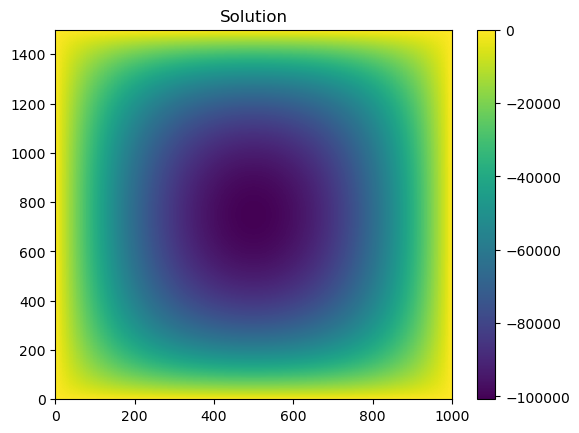

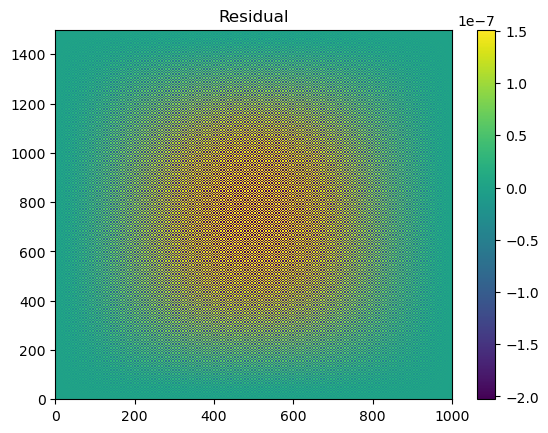

In [6]:
figure()
pcolor(grids[1].x,grids[1].y,grids[1].solution)
colorbar()
title("Solution")
show()
figure()
pcolor(grids[1].x,grids[1].y,grids[1].residual)
colorbar()
title("Residual")
show()